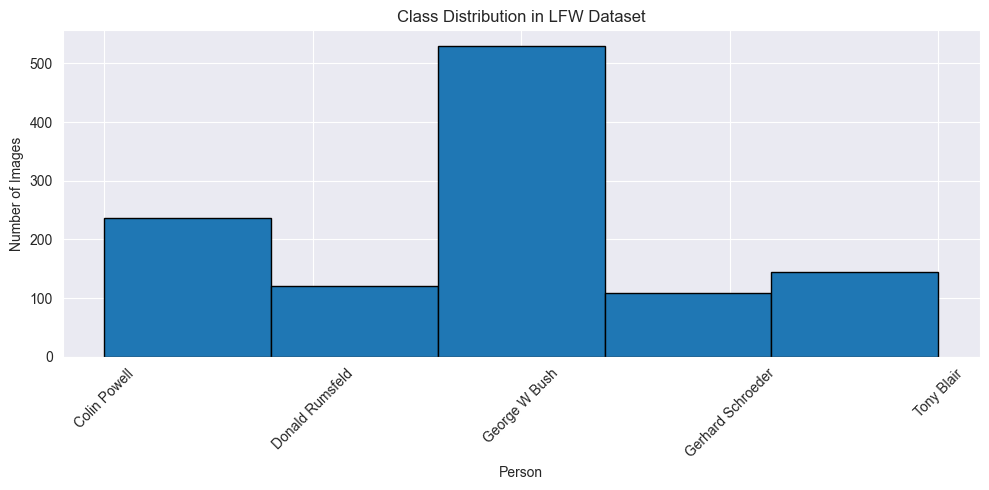

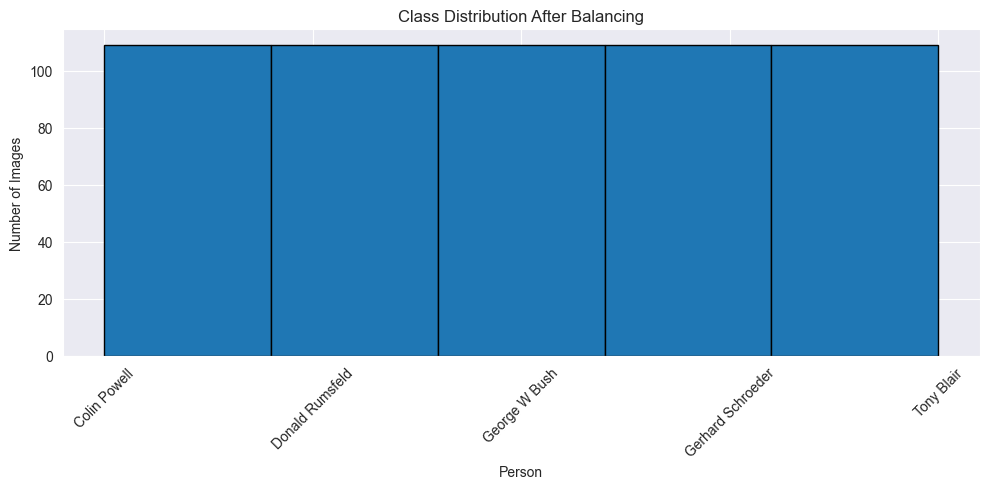

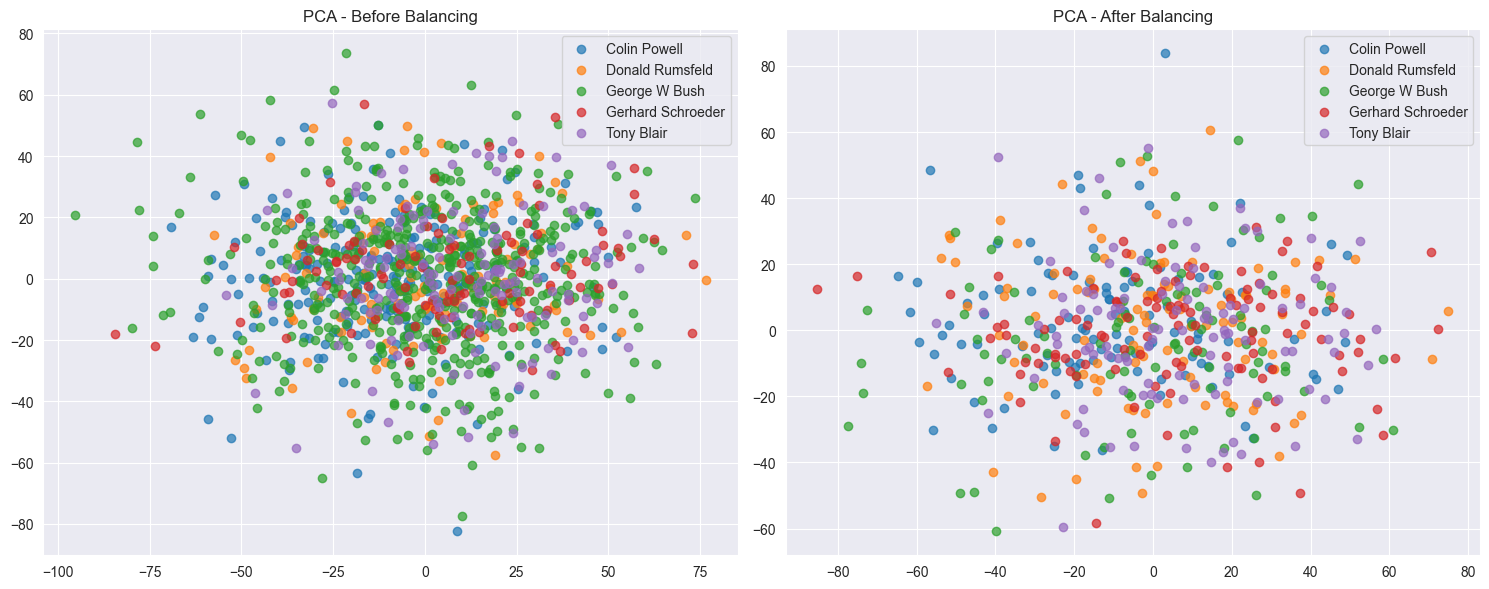

Best C: 0.1
Accuracy: 0.7798
Training Time: 3.19 seconds


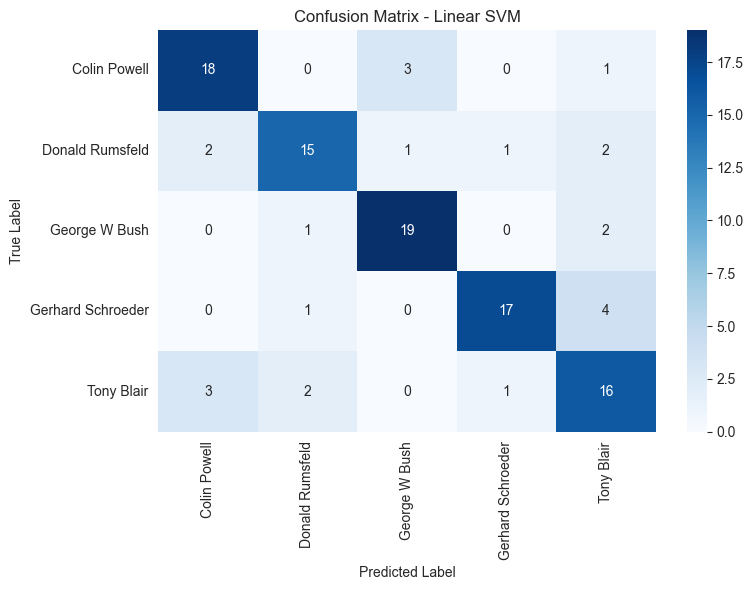

POLY Kernel - Best Score: 0.8418
Best Parameters: {'C': 1, 'coef0': 1, 'degree': 2}
RBF Kernel - Best Score: 0.6673
Best Parameters: {'C': 10, 'gamma': 0.001}
SIGMOID Kernel - Best Score: 0.5413
Best Parameters: {'C': 0.1, 'coef0': 0, 'gamma': 0.001}


C:\Users\rj3u25\PycharmProjects\ML_LAB\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rj3u25\PycharmProjects\ML_LAB\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rj3u25\PycharmProjects\ML_LAB\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\rj3u25\PycharmProjects\ML_LAB\.venv\Lib\si

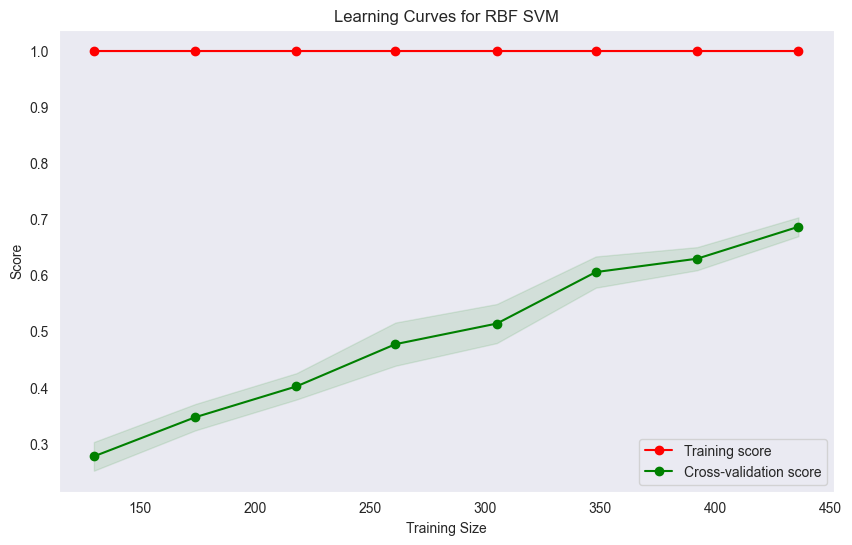

NameError: name 'cross_val_score' is not defined

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import time
import seaborn as sns

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])

plt.figure(figsize=(10, 5))
plt.hist(faces.target, bins=len(faces.target_names), edgecolor='black')
plt.xticks(range(len(faces.target_names)), faces.target_names, rotation=45)
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Class Distribution in LFW Dataset')
plt.tight_layout()
plt.show()

X = faces.data
y = faces.target

min_samples = np.min(np.bincount(y))
X_balanced = []
y_balanced = []

for i in range(len(faces.target_names)):
    X_class = X[y == i]
    y_class = y[y == i]
    X_resampled, y_resampled = resample(X_class, y_class, replace=False, n_samples=min_samples, random_state=42)
    X_balanced.append(X_resampled)
    y_balanced.append(y_resampled)

X_balanced = np.vstack(X_balanced)
y_balanced = np.hstack(y_balanced)

plt.figure(figsize=(10, 5))
plt.hist(y_balanced, bins=len(faces.target_names), edgecolor='black')
plt.xticks(range(len(faces.target_names)), faces.target_names, rotation=45)
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Class Distribution After Balancing')
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_balanced_scaled = scaler.fit_transform(X_balanced)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_balanced_pca = pca.fit_transform(X_balanced_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for i in range(len(faces.target_names)):
    ax1.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=faces.target_names[i], alpha=0.7)
ax1.set_title('PCA - Before Balancing')
ax1.legend()

for i in range(len(faces.target_names)):
    ax2.scatter(X_balanced_pca[y_balanced == i, 0], X_balanced_pca[y_balanced == i, 1], label=faces.target_names[i], alpha=0.7)
ax2.set_title('PCA - After Balancing')
ax2.legend()

plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

param_grid = {'C': [0.1, 1, 10, 100]}
svm_linear = SVC(kernel='linear', random_state=42)
grid_search = GridSearchCV(svm_linear, param_grid, cv=5, n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best C: {grid_search.best_params_['C']}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.title('Confusion Matrix - Linear SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

kernels = ['poly', 'rbf', 'sigmoid']
kernel_params = {
    'poly': {'degree': [2, 3], 'coef0': [0, 1]},
    'rbf': {'gamma': [0.001, 0.01, 0.1]},
    'sigmoid': {'gamma': [0.001, 0.01], 'coef0': [0, 1]}
}

best_kernel_scores = {}

for kernel in kernels:
    param_grid = {'C': [0.1, 1, 10]}
    param_grid.update(kernel_params[kernel])

    svm = SVC(kernel=kernel, random_state=42)
    grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_kernel_scores[kernel] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_
    }

    print(f"{kernel.upper()} Kernel - Best Score: {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")

best_rbf = best_kernel_scores['rbf']['best_estimator']

train_sizes, train_scores, test_scores = learning_curve(
    best_rbf, X_balanced_scaled, y_balanced, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves for RBF SVM')
plt.legend()
plt.grid()
plt.show()

gammas = [0.0001, 0.001, 0.01, 0.1, 1]
cv_scores = []

for gamma in gammas:
    svm = SVC(kernel='rbf', C=1, gamma=gamma, random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=5, n_jobs=-1)
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(gammas, cv_scores, 'o-')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Cross-Validation Score')
plt.title('RBF SVM Sensitivity to Gamma Parameter')
plt.grid()
plt.show()

best_overall_kernel = max(best_kernel_scores, key=lambda x: best_kernel_scores[x]['best_score'])
best_overall_params = best_kernel_scores[best_overall_kernel]['best_params']
best_overall_score = best_kernel_scores[best_overall_kernel]['best_score']

print(f"\nBest performing kernel: {best_overall_kernel}")
print(f"Best parameters: {best_overall_params}")
print(f"Best cross-validation score: {best_overall_score:.4f}")

final_svm = SVC(kernel=best_overall_kernel, **best_overall_params, random_state=42)
final_svm.fit(X_train, y_train)
final_y_pred = final_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

plt.figure(figsize=(8, 6))
cm_final = confusion_matrix(y_test, final_y_pred)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.title(f'Confusion Matrix - {best_overall_kernel.upper()} SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()